# EDA on weather data and testing API-Call

### Imports

In [ ]:
import pandas as pd 
import requests
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

### Loading API-Keys

In [ ]:
load_dotenv()

CLIENT_ID = os.getenv("CLIENT_ID")
url = "https://frost.met.no/sources/v0.jsonld"

In [ ]:
params = {
    "types": "SensorSystem",
    "name": "Gardermoen",
}

r = requests.get(url, params=params, auth=(CLIENT_ID, ""))
r.raise_for_status()
data = r.json()
for src in data.get("data", []):
    print(src.get("id"), src.get("name"))

SN4780 GARDERMOEN


### Testing the API-Call
How do we get the information we need?  
How much information is available?  

In [ ]:
params = {
    "sources": "SN4780",               # Gardermoen         
    "elements": "air_temperature,wind_speed",      # velg noen elementer
    "referencetime": "2020-01-01/2020-01-02",      # et kort intervall
    "timeresolutions": "PT1H"                      # timeverdier (valgfritt)
}

r = requests.get(url, params=params, auth=(CLIENT_ID, ""), timeout=30)

print("Status:", r.status_code)
print("URL:", r.url)
print("Content-Type:", r.headers.get("content-type"))
print("Første 500 tegn av responsen:\n", r.text[:500])

r.raise_for_status()  # kaster exception hvis noe er galt


Status: 200
URL: https://frost.met.no/observations/v0.jsonld?sources=SN4780&elements=air_temperature%2Cwind_speed&referencetime=2020-01-01%2F2020-01-02&timeresolutions=PT1H
Content-Type: application/json
Første 500 tegn av responsen:
 {
  "@context" : "https://frost.met.no/schema",
  "@type" : "ObservationResponse",
  "apiVersion" : "v0",
  "license" : "https://creativecommons.org/licenses/by/3.0/no/",
  "createdAt" : "2025-09-18T14:02:22Z",
  "queryTime" : 0.245,
  "currentItemCount" : 24,
  "itemsPerPage" : 24,
  "offset" : 0,
  "totalItemCount" : 24,
  "currentLink" : "https://frost.met.no/observations/v0.jsonld?sources=SN4780&elements=air_temperature%2Cwind_speed&referencetime=2020-01-01%2F2020-01-02&timeresolutions=PT1H"


In [ ]:
df = pd.read_csv("../data/training_data.csv")

# lag datetime (lokal Oslo-tid antatt) og konverter til UTC
df["dt_local"] = pd.to_datetime(df["date"]) + pd.to_timedelta(df["hour"], unit="h")
df["dt_local"] = df["dt_local"].dt.tz_localize("Europe/Oslo", nonexistent="shift_forward", ambiguous="NaT")
df["dt_utc"]   = df["dt_local"].dt.tz_convert("UTC")

df.head()

,airport_group,date,hour,target,feat_season,feat_sched_flights_cnt,feat_sched_concurrence,target2,dt_local,dt_utc
0,A,2018-01-01,0,0,winter,0,0,0,2018-01-01 00:00:00+01:00,2017-12-31 23:00:00+00:00
1,B,2018-01-01,0,0,winter,0,0,0,2018-01-01 00:00:00+01:00,2017-12-31 23:00:00+00:00
2,C,2018-01-01,0,0,winter,0,0,0,2018-01-01 00:00:00+01:00,2017-12-31 23:00:00+00:00
3,D,2018-01-01,0,0,winter,0,0,0,2018-01-01 00:00:00+01:00,2017-12-31 23:00:00+00:00
4,E,2018-01-01,0,0,winter,0,0,0,2018-01-01 00:00:00+01:00,2017-12-31 23:00:00+00:00


In [ ]:
params = {
    "sources": "SN4780",
    "elements": "air_temperature",
    "referencetime": "2024-10-01/2024-10-02",  # kun 1 dag
}

r = requests.get(url, params=params, auth=(CLIENT_ID, ""))
print("Status:", r.status_code)
print("URL:", r.url)
print("Body (first 300 chars):", r.text[:300])


Status: 200
URL: https://frost.met.no/observations/v0.jsonld?sources=SN4780&elements=air_temperature&referencetime=2024-10-01%2F2024-10-02
Body (first 300 chars): {
  "@context" : "https://frost.met.no/schema",
  "@type" : "ObservationResponse",
  "apiVersion" : "v0",
  "license" : "https://creativecommons.org/licenses/by/3.0/no/",
  "createdAt" : "2025-09-18T14:02:24Z",
  "queryTime" : 0.248,
  "currentItemCount" : 72,
  "itemsPerPage" : 72,
  "offset" : 0,



In [ ]:
params = {
    "sources": "SN4780",  
    "elements": "air_temperature,wind_speed,wind_from_direction,precipitation_amount",
    "referencetime": "2024-10-01/2024-10-31",
    "timeresolutions": "PT1H"
}

r = requests.get(url, params=params, auth=(CLIENT_ID, ""))
print("Status:", r.status_code)
r.raise_for_status()

rows = []
for e in r.json().get("data", []):
    ts = e.get("referenceTime")
    rec = {"timestamp_utc": pd.to_datetime(ts, utc=True)}
    for o in e.get("observations", []):
        if "value" in o:
            rec[o["elementId"]] = o["value"]
    rows.append(rec)

df = pd.DataFrame(rows).sort_values("timestamp_utc")
df.rename(columns={
    "air_temperature": "temp_C",
    "wind_speed": "wind_ms",
    "wind_from_direction": "wind_dir_deg",
    "precipitation_amount": "precip_mm"
}, inplace=True)

print(df.head(10))
print(df.tail(10))


Status: 200
              timestamp_utc  temp_C  wind_ms  wind_dir_deg
0 2024-10-01 00:00:00+00:00     7.1      1.8            25
1 2024-10-01 01:00:00+00:00     6.7      0.8            52
2 2024-10-01 02:00:00+00:00     5.6      1.3            15
3 2024-10-01 03:00:00+00:00     4.8      1.0            37
4 2024-10-01 04:00:00+00:00     3.9      1.6            95
5 2024-10-01 05:00:00+00:00     5.4      2.0            99
6 2024-10-01 06:00:00+00:00     5.0      1.5            14
7 2024-10-01 07:00:00+00:00     5.4      0.8           138
8 2024-10-01 08:00:00+00:00     5.5      0.4           167
9 2024-10-01 09:00:00+00:00     6.3      0.6            80
                timestamp_utc  temp_C  wind_ms  wind_dir_deg
710 2024-10-30 14:00:00+00:00    10.9      4.8           297
711 2024-10-30 15:00:00+00:00    10.0      3.5           277
712 2024-10-30 16:00:00+00:00     8.6      0.9           329
713 2024-10-30 17:00:00+00:00     8.1      2.5           276
714 2024-10-30 18:00:00+00:00     

In [ ]:
# Antall manglende verdier per kolonne
print("Missing values per column:")
print(df.isna().sum())

# Sjekk for duplikater basert på tidsstempel
duplicates = df.duplicated(subset="timestamp_utc").sum()
print(f"\nAntall duplikater på timestamp_utc: {duplicates}")


Missing values per column:
timestamp_utc    0
temp_C           0
wind_ms          0
wind_dir_deg     0
dtype: int64

Antall duplikater på timestamp_utc: 0


### Plotting

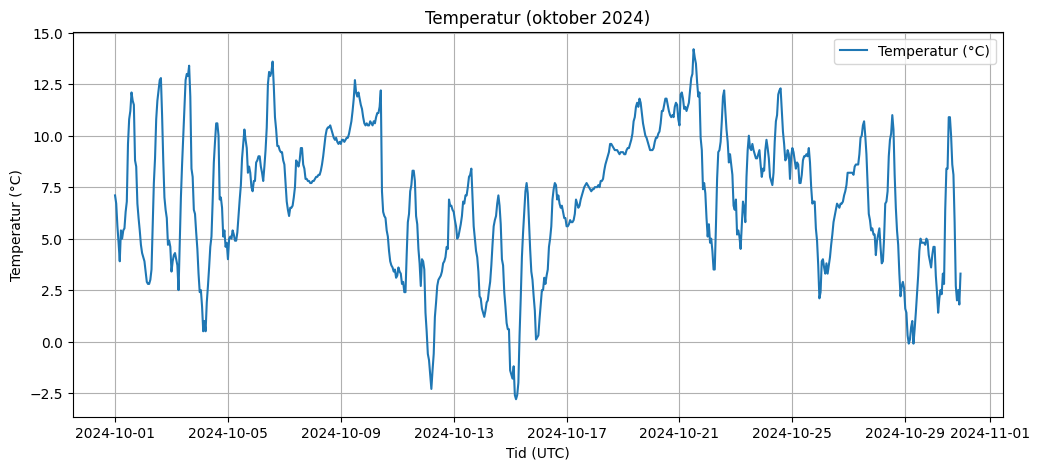

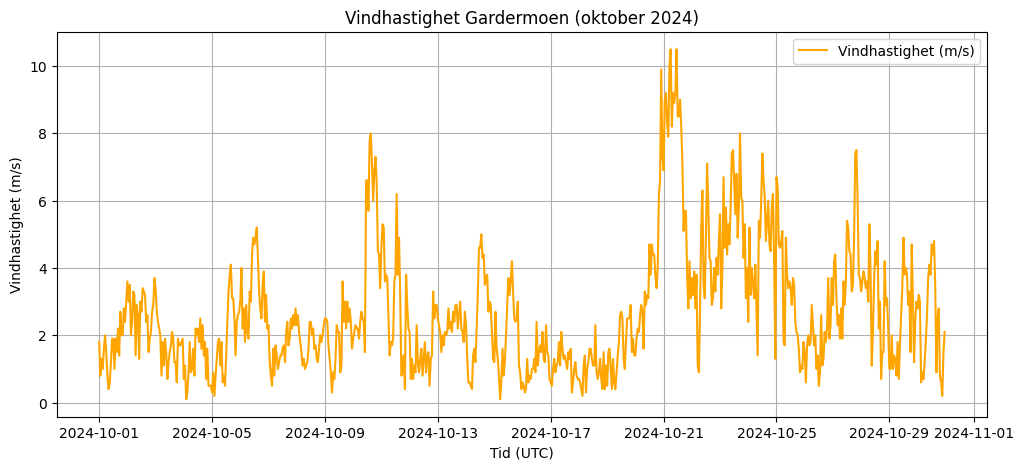

Ingen nedbørsdata (mangler 'precip_mm' / 'precipitation_amount').


In [ ]:

# Sett tidskolonnen som index
df = df.set_index("timestamp_utc")


# Temperatur over tid
plt.figure(figsize=(12,5))
plt.plot(df.index, df["temp_C"], label="Temperatur (°C)")
plt.xlabel("Tid (UTC)")
plt.ylabel("Temperatur (°C)")
plt.title("Temperatur (oktober 2024)")
plt.legend()
plt.grid(True)
plt.show()

# Vindstyrke over tid
plt.figure(figsize=(12,5))
plt.plot(df.index, df["wind_ms"], color="orange", label="Vindhastighet (m/s)")
plt.xlabel("Tid (UTC)")
plt.ylabel("Vindhastighet (m/s)")
plt.title("Vindhastighet Gardermoen (oktober 2024)")
plt.legend()
plt.grid(True)
plt.show()

# Nedbør (søyleplott)
if has_precip:
    plt.figure(figsize=(12,5))
    plt.bar(df.index, df["precip_mm"], width=0.03, label="Nedbør (mm)")
    plt.xlabel("Tid (UTC)"); plt.ylabel("Nedbør (mm)")
    plt.title("Nedbør (oktober 2024)")
    plt.legend(); plt.show()
else:
    print("Ingen nedbørsdata (mangler 'precip_mm' / 'precipitation_amount').")



The weather data contains the wind force, wind direction and temperature which would be great as features for out model. However, we are having troubles with the API-call and cannot get for weather for every group. We are also having problems with getting future weather data.  